In [6]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as st
import math
from tqdm.notebook import tqdm
import iteration_utilities
import statsmodels
import scipy.optimize
import scipy.spatial.distance as sd
from lmfit import *
from matplotlib.lines import Line2D

mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['font.family'] = 'sans-serif'
plt.rcParams['figure.figsize'] = (5, 3)
mpl.rcParams['pdf.fonttype'] = 42
sns.set_style(
    'ticks',
    {
        'xtick.major.size': 4,
        'ytick.major.size': 4,
        'font_color': 'k',
        'axes.edgecolor': 'k',
        'xtick.color': 'k',
        'ytick.color': 'k',
    },
)
sns.set_context('talk', font_scale=1.0)

from cytoflow import *
import itertools
import more_itertools
import functools, operator

from sklearn.mixture import GaussianMixture

from matplotlib.lines import Line2D

effectors = [73, 214, 216]
reporters = ["CMV", "PGK", "PEF"]
days = [1, 2, 3, 4, 5]
asvs = [0, 0.01, 0.1, 1]
doxs = [0, 10, 100]
reps = [1, 2]

# Importing Tubes

In [7]:
row_letters = ["A", "B", "C", "D", "E", "F", "G", "H"]
col_nums = list(range(13))


def reflect_coord(coord, day, reporter):
    if day != 1 or reporter == "CMV":
        return coord
    r = coord[0]
    c = coord[1:]

    n_r = row_letters[len(row_letters) - (row_letters.index(r) + 1)]
    n_c = col_nums[len(col_nums) - (col_nums.index(int(c)-1) + 1)]
    
    return n_r + str(n_c)

def get_plate_coord(effector, asv, dox, replicate):
    asvs = [0, 0.01, 0.1, 1.0]
    doxs = [0, 10, 100]

    r_ind = asvs.index(asv) + 4 * (effector == 73)  # swapped 73 and 216 on plate
    c_ind = 1 + doxs.index(dox) + 3 * (replicate == 2) + 6 * (effector == 214)

    return row_letters[r_ind] + str(col_nums[c_ind])


def get_plate_dir(day, reporter):
    plate_dict = {
        1: {
            "CMV": "axm-20220829_stapl_d1_mincmv-20220829-1811",
            "PGK": "axm-20220829_stapl_d1_pgk-20220829-1844",
            "PEF": "axm-20220829_stapl_d1_pef-20220829-1913",
        },
        2: {
            "CMV": "axm-20220830_stapl_d2_mincmv-20220830-1650",
            "PGK": "axm-20220830_stapl_d2_pgk-20220830-1720",
            "PEF": "axm-20220830_stapl_d2_pef-20220830-1753",
        },
        3: {
            "CMV": "axm-20220831_stapl_d3_cmv-20220831-1715",
            "PGK": "axm-20220831_stapl_d3_pgk-20220831-1751",
            "PEF": "axm-20220831_stapl_d3_pef-20220831-1828",
        },
        4: {
            "CMV": "axm-20220901_stapl_d4_mincmv-20220901-1652",
            "PGK": "axm-20220901_stapl_d4_pgk-20220901-1740",
            "PEF": "axm-20220901_stapl_d4_pef-20220901-1819",
        },
        5: {
            "CMV": "axm-20220902_stapl_d5_plate1(cmv-pgk-cmv)-20220902-1743",
            "PGK": "axm-20220902_stapl_d5_plate2(pgk-cmv-pgk)-20220902-1823",
            "PEF": "axm-20220902_stapl_d5_pef-20220902-1900",
        },
    }
    return plate_dict[day][reporter]


def get_tube(effector, reporter, day, asv, dox, rep):
    new_reporter = reporter
    if day == 5:
        if effector == 214 and reporter != "pef":
            new_reporter = (
                "CMV" if reporter == "PGK" else "PGK"
            )  # swap it out bc of mislabeling --> pgk was flowed as if it were cmv
    return (
        "./data/"
        + get_plate_dir(day, new_reporter)
        + "/"
        + reflect_coord(get_plate_coord(effector, asv, dox, rep), day, reporter)
        + ".fcs"
    )

In [8]:
def get_ex0(effector, reporter, day, asv, dox, rep):
    op0 = ImportOp(
        conditions={
            "effector": "category",
            "reporter": "category",
            "day": "float",
            "asv": "float",
            "dox": "float",
            "replicate": "float",
        },
        tubes=[
            Tube(
                conditions={
                    "effector": effector,
                    "reporter": reporter,
                    "day": day,
                    "asv": asv,
                    "dox": dox,
                    "replicate": rep,
                },
                file=get_tube(effector, reporter, day, asv, dox, rep),
                conditions_list=[
                    "effector",
                    "reporter",
                    "day",
                    "asv",
                    "dox",
                    "replicate",
                ],
            )
        ],
        channels={
            "mCitrine-A": "mCitrine-A",
            "mCherry-A": "mCherry-A",
            "FSC 488/10-A": "FSC 488/10-A",
            "SSC 488/10-A": "SSC 488/10-A",
        },
    )

    ex0 = op0.apply()
    return ex0

In [9]:
iters = [effectors, reporters, days, asvs, doxs, reps]
len_total_iters = functools.reduce(operator.mul, map(len, iters), 1)
# list(itertools.product(*iters))

experiments = [
    get_ex0(*arr)
    for arr in tqdm(itertools.product(*iters), total=len_total_iters)
]

ex0 = experiments[0]
ex0.data = pd.concat([e.data for e in experiments])
ex0.data.head()

  0%|          | 0/1080 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Live Cell + mCherry Gating

In [ ]:
%%time

dens_op = DensityGateOp(
    name="P1",
    xchannel="FSC 488/10-A",
    xscale="log",
    ychannel="SSC 488/10-A",
    yscale="log",
    keep=0.9,
)

dens_op.estimate(ex0)
ex_1 = dens_op.apply(ex0)
dens_op.default_view().plot(ex0, height=4)

In [ ]:
op_2 = ThresholdOp(name="mCherry", threshold=3e7, channel="mCherry-A")
ex_2 = op_2.apply(ex_1)
op_2.default_view(subset="(P1==True)", scale="log").plot(ex_2)

In [ ]:
all_cells = ex_2.data
all_cells = all_cells[(all_cells['P1'])&(all_cells['mCherry'])]
all_cells.to_csv('./data/all_cells_mch_live.csv', index=False)
all_cells

# Citrine Analysis

In [10]:
df = pd.read_csv("./data/all_cells_mch_live.csv")

  0%|          | 0/5 [00:00<?, ?it/s]

[[7.04819579]
 [6.96888209]
 [6.95422123]
 [6.99671238]
 [7.01485916]]


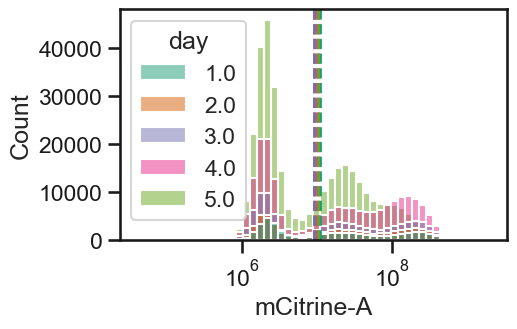

In [11]:
# Compute mCitrine threshold
data = df.copy()
data = data[data["asv"] == 0]
data = data[data["dox"] == 0]


def get_citrine_threshold(day):
    dx = df
    dx = dx[dx["day"] == day]
    dx = dx[dx["dox"] == 0]
    dx = dx[dx["asv"] == 0]

    logmC = np.log10(dx["mCitrine-A"])

    gm = GaussianMixture(n_components=2).fit(np.array(logmC).reshape(-1, 1))
    m0 = gm.means_[0][0]
    m1 = gm.means_[1][0]
    c0 = gm.covariances_[0][0]
    c1 = gm.covariances_[1][0]
    mean = m0 if m0 <= m1 else m1
    cov = c0 if m0 <= m1 else c1
    # return [10**7]
    return np.power(10, mean + 5 * np.sqrt(cov))


g = sns.histplot(
    data=data, x="mCitrine-A", hue="day", palette="Dark2", log_scale=True, bins=50
)

days = [1, 2, 3, 4, 5]

for d in tqdm(days):
    g.axvline(
        x=get_citrine_threshold(d),
        color=list(sns.color_palette("Dark2"))[days.index(d)],
        linestyle="--",
        lw=2,
    )

print(np.log10([get_citrine_threshold(d) for d in [1, 2, 3, 4, 5]]))

citrine_threshold = 1e7

In [12]:
effector_dict = {
    73: "FOXO3-StaPL-ZNF10",
    214: "U2AF4-StaPL-WWP2",
    216: "ANM2-StaPL-KIBRA",
}

df["mCitrine On"] = df["mCitrine-A"] >= citrine_threshold
df["description"] = [effector_dict[d] for d in list(df["effector"])]
data = df.copy()
data = data[
    [
        "reporter",
        "effector",
        "description",
        "day",
        "asv",
        "dox",
        "replicate",
        "mCitrine On",
        "mCitrine-A",
    ]
].reset_index(drop=True)
data.head()

,reporter,effector,description,day,asv,dox,replicate,mCitrine On,mCitrine-A
0,CMV,73,FOXO3-StaPL-ZNF10,1.0,0.0,0.0,1.0,False,1396736.0
1,CMV,73,FOXO3-StaPL-ZNF10,1.0,0.0,0.0,1.0,False,2145792.0
2,CMV,73,FOXO3-StaPL-ZNF10,1.0,0.0,0.0,1.0,False,3070976.0
3,CMV,73,FOXO3-StaPL-ZNF10,1.0,0.0,0.0,1.0,False,4026624.0
4,CMV,73,FOXO3-StaPL-ZNF10,1.0,0.0,0.0,1.0,False,9669888.0


## Quick and Dirty

In [13]:
%%time

gdf = (
    data.groupby(
        ["effector", "description", "day", "reporter", "asv", "dox", "replicate"]
    )
    .mean()
    .reset_index()
)
gdf = gdf.pivot(
    index=["effector", "description", "day", "reporter", "replicate", "asv"],
    columns=["dox"],
    values="mCitrine On",
).reset_index()
gdf["cit_on_10dox"] = (gdf[10] - gdf[0])/(1 - gdf[0])
gdf["cit_on_100dox"] = (gdf[100] - gdf[0])/(1-gdf[0])
gdf = gdf[
    [
        "effector",
        "description",
        "day",
        "reporter",
        "replicate",
        "asv",
        "cit_on_10dox",
        "cit_on_100dox",
    ]
]
gdf

CPU times: user 1.76 s, sys: 309 ms, total: 2.07 s
Wall time: 2.07 s


dox,effector,description,day,reporter,replicate,asv,cit_on_10dox,cit_on_100dox
0,73,FOXO3-StaPL-ZNF10,1.0,CMV,1.0,0.00,0.040818,0.826220
1,73,FOXO3-StaPL-ZNF10,1.0,CMV,1.0,0.01,0.002802,0.713839
2,73,FOXO3-StaPL-ZNF10,1.0,CMV,1.0,0.10,-0.002940,0.114122
3,73,FOXO3-StaPL-ZNF10,1.0,CMV,1.0,1.00,0.002908,0.075844
4,73,FOXO3-StaPL-ZNF10,1.0,CMV,2.0,0.00,0.066571,0.790179
...,...,...,...,...,...,...,...,...
355,216,ANM2-StaPL-KIBRA,5.0,PGK,1.0,1.00,-0.033738,0.323764
356,216,ANM2-StaPL-KIBRA,5.0,PGK,2.0,0.00,0.002108,0.006099
357,216,ANM2-StaPL-KIBRA,5.0,PGK,2.0,0.01,-0.000085,0.001937
358,216,ANM2-StaPL-KIBRA,5.0,PGK,2.0,0.10,-0.004285,0.005889


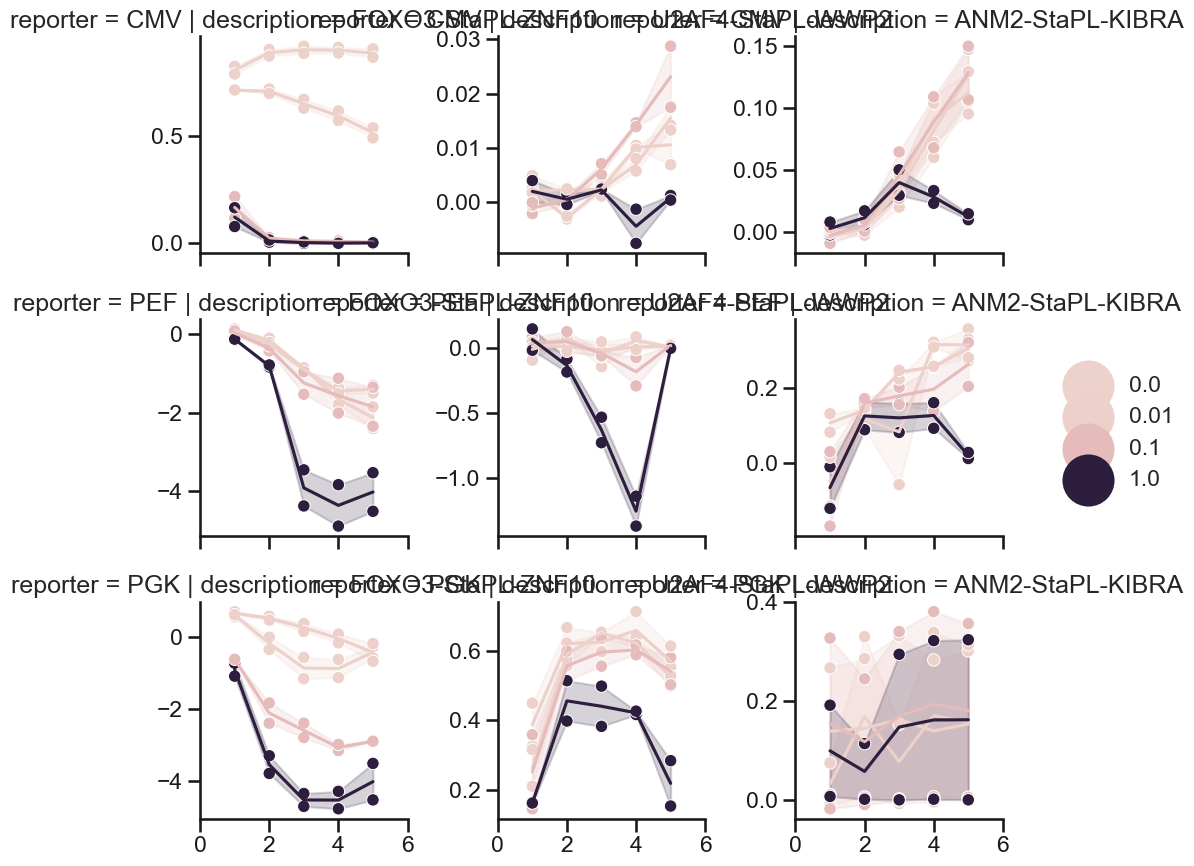

In [14]:
g = sns.FacetGrid(
    gdf,
    col="description",
    row = "reporter",
    xlim=(0, 6),
    sharey=False
)
g.map_dataframe(
    sns.lineplot,
    x="day",
    y="cit_on_100dox",
    hue="asv",
)
g.map_dataframe(
    sns.scatterplot,
    x="day",
    y="cit_on_100dox",
    hue="asv",
)
g.add_legend()

# Summary Plots

## Histograms

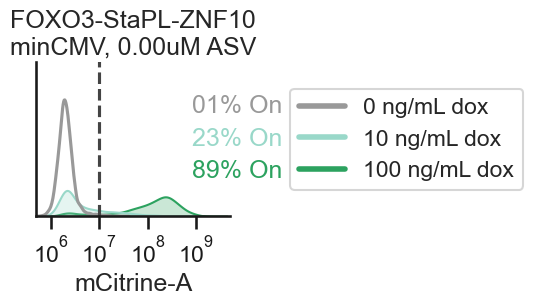

In [15]:
def make_histogram_dox(plasmid, reporter, day, ax, asv=0, ymax=4, legend=True):
    cdf = data[
        (data["reporter"] == reporter)
        & (data["effector"] == plasmid)
        & (data["day"] == day)
        & (data["asv"] == asv)
    ]

    sns.kdeplot(
        data=cdf[(cdf["day"] == day) & (cdf["dox"] == 0)],
        x="mCitrine-A",
        hue="dox",
        palette=["#999999"],
        log_scale=True,
        fill=False,
        legend=False,
        ax=ax,
    )

    sns.kdeplot(
        data=cdf[(cdf["day"] == day) & (cdf["dox"] != 0)],
        x="mCitrine-A",
        hue="dox",
        palette=["#99d8c9", "#2ca25f"],
        log_scale=True,
        fill=True,
        legend=False,
        ax=ax,
    )

    ax.set_yticks([])
    ax.set_ylim([0, ymax])
    ax.set_xscale("log")
    ax.set_xlim(5e5, 5e9)
    ax.set_xticks([1e6, 1e7, 1e8, 1e9])
    ax.set_ylabel("")

    qdf = cdf[cdf["effector"] == plasmid]
    qasv_on = qdf[qdf["dox"] == 0]
    qasv_on = np.mean(list(qasv_on["mCitrine On"]))
    pasv_on = qdf[(qdf["dox"] == 10)]
    pasv_on = np.mean(list(pasv_on["mCitrine On"]))
    masv_on = qdf[(qdf["dox"] == 100)]
    masv_on = np.mean(list(masv_on["mCitrine On"]))

    ax.axvline(1e7, ymin=0, ymax=2, color="#444444", linestyle="--")
    ax.text(
        8e8, ymax / 4 * 2.7, "{:02.0f}".format(qasv_on * 100) + "% On", color="#999999"
    )
    ax.text(
        8e8, ymax / 4 * 1.85, "{:02.0f}".format(pasv_on * 100) + "% On", color="#99d8c9"
    )
    ax.text(
        8e8, ymax / 4 * 1, "{:02.0f}".format(masv_on * 100) + "% On", color="#2ca25f"
    )

    rep_title = "minCMV" if reporter == "CMV" else reporter
    ax.set_title(
        list(cdf["description"])[0] + "\n" + rep_title + ", {:.02f}".format(asv) + "uM ASV"
    )

    if legend:
        custom_lines = [
            Line2D([0], [0], color="#999999", lw=4),
            Line2D([0], [0], color="#99d8c9", lw=4),
            Line2D([0], [0], color="#2ca25f", lw=4),
        ]
        ax.legend(
            custom_lines,
            ["0 ng/mL dox", "10 ng/mL dox", "100 ng/mL dox"],
            loc="center left",
            bbox_to_anchor=(1.25, 0.5),
        )


fig, ax = plt.subplots(figsize=(2.5, 2))
make_histogram_dox(73, "CMV", 2, ax, 0)
sns.despine(fig)
fig.savefig("./plots/073_minCMV_0asv_day2_histograms.pdf", bbox_inches="tight")

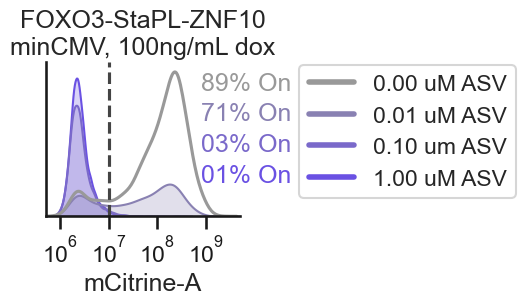

In [16]:
def make_histogram_asv(plasmid, reporter, day, ax, dox=100, ymax=1, legend=True):
    palette = ["#999999", "#8981B2", "#7A69CA", "#6a51e3"]

    cdf = data[
        (data["reporter"] == reporter)
        & (data["effector"] == plasmid)
        & (data["day"] == day)
        & (data["dox"] == dox)
    ]
    
    sns.kdeplot(
        data=cdf[(cdf["day"] == day) & (cdf["asv"] == 0)],
        x="mCitrine-A",
        hue="asv",
        palette=[palette[0]],
        log_scale=True,
        fill=False,
        legend=False,
        ax=ax,
    )

    sns.kdeplot(
        data=cdf[(cdf["day"] == day) & (cdf["asv"] != 0) & (cdf["asv"])],
        x="mCitrine-A",
        hue="asv",
        palette=palette[1:],
        log_scale=True,
        fill=True,
        legend=False,
        ax=ax,
    )
    
    ax.axvline(1e7, ymin=0, ymax=ymax, color="#444444", linestyle="--")
    ax.set_yticks([])
    ax.set_ylim([0, ymax])
    ax.set_xscale("log")
    ax.set_xlim(5e5, 5e9)
    ax.set_xticks([1e6, 1e7, 1e8, 1e9])
    ax.set_ylabel("")

    def get_frac_on(asv):
        qdf = cdf[cdf["effector"] == plasmid]
        adf = qdf[(qdf["asv"] == asv)]
        return np.mean(list(adf["mCitrine On"]))

    fracs = [get_frac_on(a) for a in asvs]
    yvals = [0.82, 0.62, 0.42, 0.22] 
    yvals = [y * ymax for y in yvals]
    for f, y, p in zip(fracs, yvals, palette):
        ax.text(8e8, y, "{:02.0f}".format(f * 100) + "% On", color=p)
        
    rep_title = "minCMV" if reporter == "CMV" else reporter
    ax.set_title(
        list(cdf["description"])[0] + "\n" + rep_title + ", {:.0f}".format(dox) + "ng/mL dox"
    )

    if legend:
        custom_lines = [
            Line2D([0], [0], color=palette[0], lw=4),
            Line2D([0], [0], color=palette[1], lw=4),
            Line2D([0], [0], color=palette[2], lw=4),
            Line2D([0], [0], color=palette[3], lw=4),
        ]
        ax.legend(
            custom_lines,
            ["0.00 uM ASV", "0.01 uM ASV", "0.10 um ASV", "1.00 uM ASV"],
            loc="center left",
            bbox_to_anchor=(1.25, 0.55),
        )


fig, ax = plt.subplots(figsize=(2.5, 2))
make_histogram_asv(73, "CMV", 2, ax, dox=100, ymax=1, legend=True)
sns.despine(fig)
fig.savefig("./plots/073_minCMV_100dox_day2_histograms.pdf", bbox_inches="tight")

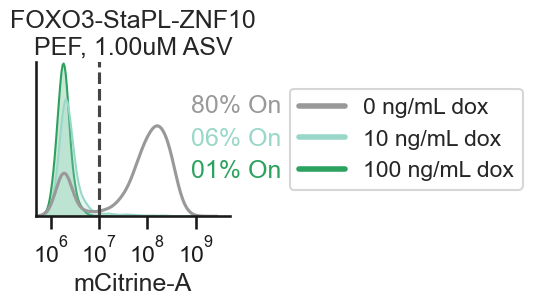

In [17]:
fig, ax = plt.subplots(figsize=(2.5, 2))
make_histogram_dox(73, "PEF", 5, ax, asv=1, ymax=1.5)
sns.despine(fig)
fig.savefig("./plots/073_PEF_1asv_day5_histograms.pdf", bbox_inches = "tight")

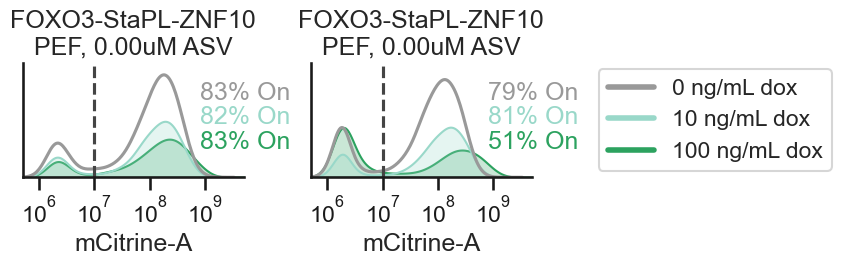

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3))
make_histogram_dox(73, "PEF", 1, ax[0], asv=0, ymax=1, legend=False)
make_histogram_dox(73, "PEF", 5, ax[1], asv=0, ymax=1, legend=True)
sns.despine(fig)
plt.tight_layout()
# fig.savefig("./plots/073_PEF_1asv_day5_histograms.pdf", bbox_inches = "tight")

## Heatmaps

In [19]:
qdf = df[(df["effector"] == 73) & (df["reporter"] == "CMV") & (df["day"] == 2)]
q = (
    qdf[["dox", "asv", "mCitrine On"]]
    .groupby(["dox", "asv"])
    .mean()
    .reset_index()
    .pivot(index="asv", columns="dox", values = "mCitrine On")
)
q[10] = (q[10] - q[0])/(1 - q[0])
q[100] = (q[100] - q[0])/(1 - q[0])
q.transpose()

# q    .pivot(index="dox", columns="asv", values="mCitrine On")
#     .sort_index(ascending=False)
q

dox,0.0,10.0,100.0
asv,,,
0.00,0.006151,0.220851,0.888032
0.01,0.004294,0.248074,0.708108
0.10,0.008124,-0.000473,0.020849
1.00,0.005770,0.000904,0.007269


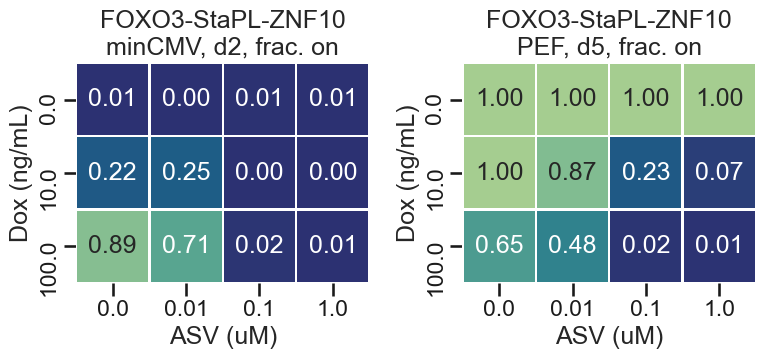

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

qdf = df[(df["effector"] == 73) & (df["reporter"] == "CMV") & (df["day"] == 2)]
qc = (
    qdf[["dox", "asv", "mCitrine On"]]
    .groupby(["dox", "asv"])
    .mean()
    .reset_index()
    .pivot(index="asv", columns="dox", values = "mCitrine On")
)
qc[10] = np.maximum(0, (qc[10] - qc[0])/(1 - qc[0]))
qc[100] = np.maximum(0, (qc[100] - qc[0])/(1 - qc[0]))
qc = qc.transpose()
g1 = sns.heatmap(
    data=qc,
    vmin=0,
    vmax=1,
    cmap="crest_r",
    cbar=False,
    annot=True,
    fmt = ".2f",
    linewidths = 1,
    square = True,
    ax=ax[0]
)
g1.set_xlabel("ASV (uM)")
g1.set_ylabel("Dox (ng/mL)")
g1.set_title("FOXO3-StaPL-ZNF10\nminCMV, d2, frac. on")

qdf = df[(df["effector"] == 73) & (df["reporter"] == "PEF") & (df["day"] == 5)]
qe = (
    qdf[["dox", "asv", "mCitrine On"]]
    .groupby(["dox", "asv"])
    .mean()
    .reset_index()
    .pivot(index="asv", columns="dox", values = "mCitrine On")
)
qe[10] = np.minimum(1, 1 - (qe[0]-qe[10])/qe[0])
qe[100] = np.minimum(1, 1 - (qe[0]-qe[100])/qe[0])
qe[0] = np.minimum(1, 1 - (qe[0] - qe[0])/qe[0])
qe = qe.transpose()
g2 = sns.heatmap(
    data=qe,
    vmin=0,
    vmax=1,
    cmap="crest_r",
    cbar=False,
    annot=True,
    fmt = ".2f",
    linewidths = 1,
    square = True,
    ax=ax[1]
)
g2.set_xlabel("ASV (uM)")
g2.set_ylabel("Dox (ng/mL)")
g2.set_title("FOXO3-StaPL-ZNF10\nPEF, d5, frac. on")

plt.tight_layout()

fig.savefig("./plots/073_doxasv_cmvpef.pdf", bbox_inches = "tight")

In [21]:
def get_lineplot_df(df, cmv=True):
    qdf = (
        df[["dox", "asv", "mCitrine On", "replicate"]]
        .groupby(["dox", "asv", "replicate"])
        .mean()
        .reset_index()
        .pivot(index="asv", columns=["dox", "replicate"], values="mCitrine On")
        .stack()
        .reset_index()
    )
    
    if cmv:
        qdf[10] = np.maximum(0, (qdf[10]-qdf[0])/(1-qdf[0]))
        qdf[100] = np.maximum(0, (qdf[100]-qdf[0])/(1-qdf[0]))
    else:
        qdf[10] = 1 - np.minimum(1, 1 - (qdf[0] - qdf[10])/(qdf[0]))
        qdf[100] = 1 - np.minimum(1, 1 - (qdf[0] - qdf[100])/(qdf[0]))
    qdf = (
        qdf[["asv", "replicate", 10, 100]]
        .pivot_table(index="asv", columns=["replicate"], values=[10, 100])
        .stack()
        .reset_index()
        .melt(
            id_vars=["asv", "replicate"],
            value_vars=[10, 100],
            value_name="mCitrine On",
            var_name="dox",
        )
    )
    qdf["asv_i"] = [asvs.index(a) for a in list(qdf["asv"])]

    return qdf

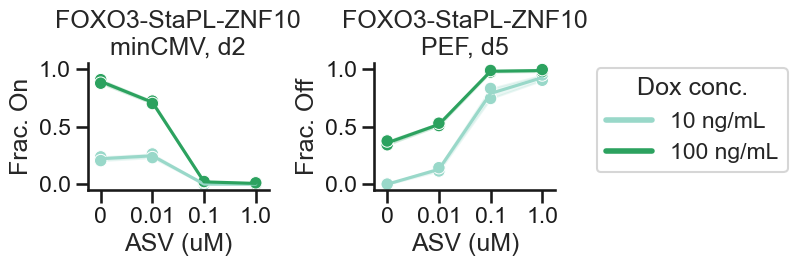

In [22]:
pal = ["#99d8c9", "#2ca25f"]

fig, ax = plt.subplots(1, 2, figsize=(6, 3))


qdf = df[(df["effector"] == 73) & (df["reporter"] == "CMV") & (df["day"] == 2)]
qc = get_lineplot_df(qdf, True)

sns.lineplot(
    data=qc,
    x="asv_i",
    y="mCitrine On",
    hue="dox",
    palette=pal,
    legend=False,
    ax=ax[0],
)
sns.scatterplot(
    data=qc,
    x="asv_i",
    y="mCitrine On",
    hue="dox",
    palette=pal,
    legend=False,
    ax=ax[0],
)

qdf = df[(df["effector"] == 73) & (df["reporter"] == "PEF") & (df["day"] == 5)]
qc = get_lineplot_df(qdf, False)
sns.lineplot(
    data=qc,
    x="asv_i",
    y="mCitrine On",
    hue="dox",
    palette=pal,
    legend=False,
    ax=ax[1],
)
sns.scatterplot(
    data=qc,
    x="asv_i",
    y="mCitrine On",
    hue="dox",
    palette=pal,
    legend=False,
    ax=ax[1],
)

for a in ax.flat:
    a.set_xlim(-0.25, 3.25)
    a.set_xticks([0, 1, 2, 3])
    a.set_xticklabels([0, 0.01, 0.1, 1.0])
    a.set_xlabel("ASV (uM)")
    a.set_ylim(-0.05, 1.05)
    a.set_yticks([0, 0.5, 1.0])
ax[0].set_title("FOXO3-StaPL-ZNF10\nminCMV, d2")
ax[0].set_ylabel("Frac. On")
ax[1].set_title("FOXO3-StaPL-ZNF10\nPEF, d5")
ax[1].set_ylabel("Frac. Off")


custom_lines = [
    Line2D([0], [0], color=pal[0], lw=4),
    Line2D([0], [0], color=pal[1], lw=4),
]

sns.despine(fig)

plt.tight_layout()

ax[0].legend(
    custom_lines,
    ["10 ng/mL", "100 ng/mL"],
    title="Dox conc.",
    loc="center left",
    bbox_to_anchor=(2.75, 0.55),
)

fig.savefig("./plots/073_cmvpef_asvdox_lineplots.pdf", bbox_inches="tight")

## Summary Lineplots

In [23]:
def get_frac(mdox, pdox, prom):
    if prom == "CMV":
        return (pdox - mdox)/(1 - mdox)
    else:
        #1 - np.minimum(1, 1 - (qdf[0] - qdf[10])/(qdf[0]))
        return (mdox - pdox)/mdox

In [24]:
qdf = (
    data.groupby(
        ["reporter", "effector", "description", "day", "asv", "dox", "replicate"]
    )
    .mean()
    .reset_index()
    .pivot(
        index="asv",
        columns=["dox", "replicate", "reporter", "effector", "day"],
        values="mCitrine On",
    )
    .stack()
    .stack()
    .stack()
    .stack()
    .reset_index()
)
qdf[10] = [
    get_frac(m, p, r)
    for m, p, r in zip(list(qdf[0]), list(qdf[10]), list(qdf["reporter"]))
]
qdf[100] = [
    get_frac(m, p, r)
    for m, p, r in zip(list(qdf[0]), list(qdf[100]), list(qdf["reporter"]))
]
qdf[0] = [0 for x, r in zip(list(qdf[0]), list(qdf["reporter"]))]
qdf = qdf.reset_index()
qdf = qdf.melt(
    id_vars=["reporter", "effector", "day", "asv", "replicate"],
    value_vars=[10, 100],
    value_name="mCitrine On",
    var_name="dox",
)
qdf = qdf[qdf["reporter"].isin(["CMV", "PEF"])]

qdf = (
    qdf.pivot(
        index="effector",
        columns=["day", "dox", "replicate", "asv", "reporter"],
        values="mCitrine On",
    )
    .stack()
    .stack()
    .stack()
    .stack()
    .reset_index()
)
qdf[0.0] = [
    0 if p == "CMV" else 0 for p in list(qdf["reporter"])
]
qdf = qdf.reset_index(drop=True).melt(
    id_vars=["effector", "reporter", "asv", "replicate", "dox"],
    value_vars=[0, 1, 2, 3, 4, 5],
    value_name="mCitrine On",
    var_name="day",
)
qdf
# qdf["replicate"]

,effector,reporter,asv,replicate,dox,day,mCitrine On
0,73,CMV,0.00,1.0,10.0,0.0,0.000000
1,73,CMV,0.00,1.0,100.0,0.0,0.000000
2,73,CMV,0.00,2.0,10.0,0.0,0.000000
3,73,CMV,0.00,2.0,100.0,0.0,0.000000
4,73,CMV,0.01,1.0,10.0,0.0,0.000000
...,...,...,...,...,...,...,...
571,216,PEF,0.10,2.0,100.0,5.0,-0.013763
572,216,PEF,1.00,1.0,10.0,5.0,0.003083
573,216,PEF,1.00,1.0,100.0,5.0,-0.000598
574,216,PEF,1.00,2.0,10.0,5.0,-0.001313


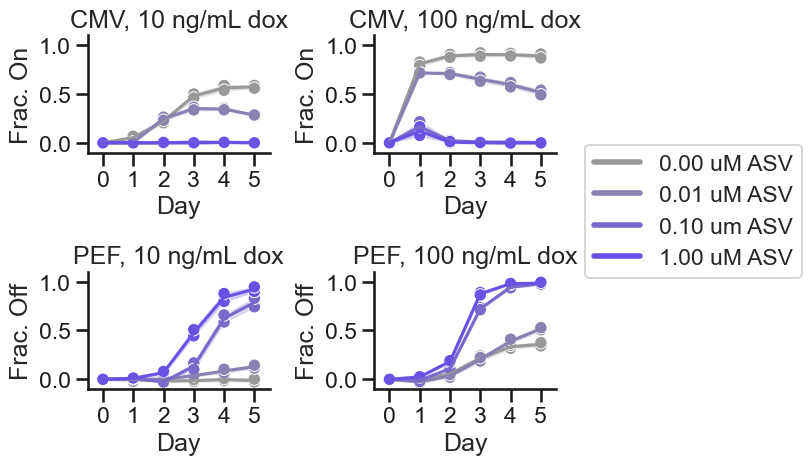

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(6, 5))

dox_levels = [10, 100]
promoters = ["CMV", "PEF"]

for i, a in enumerate(ax.flat):
    sns.lineplot(
        data=qdf[
            (qdf["effector"] == 73)
            & (qdf["reporter"] == promoters[i // 2])
            & (qdf["dox"] == dox_levels[i % 2])
        ],
        x="day",
        y="mCitrine On",
        hue="asv",
        palette=["#999999", "#8981B2", "#7A69CA", "#6a51e3"],
        legend=False,
        ax=a,
    )
    sns.scatterplot(
        data=qdf[
            (qdf["effector"] == 73)
            & (qdf["reporter"] == promoters[i // 2])
            & (qdf["dox"] == dox_levels[i % 2])
        ],
        x="day",
        y="mCitrine On",
        hue="asv",
        palette=["#999999", "#8981B2", "#7A69CA", "#6a51e3"],
        legend=False,
        ax=a,
    )

    if i <= 1:
        a.set_ylabel("Frac. On") 
    else:
        a.set_ylabel("Frac. Off")
    a.set_ylim(-0.1, 1.1)
    a.set_yticks([0, 0.5, 1.0])

    a.set_xlabel("Day")
    a.set_xlim(-0.5, 5.5)
    a.set_xticks([0, 1, 2, 3, 4, 5])

    a.set_title(promoters[i // 2] + ", " + str(dox_levels[i % 2]) + " ng/mL dox")


sns.despine(fig)
plt.tight_layout()

palette = ["#999999", "#8981B2", "#7A69CA", "#6a51e3"]
custom_lines = [
    Line2D([0], [0], color=palette[0], lw=4),
    Line2D([0], [0], color=palette[1], lw=4),
    Line2D([0], [0], color=palette[2], lw=4),
    Line2D([0], [0], color=palette[3], lw=4),
]
ax.flat[0].legend(
    custom_lines,
    ["0.00 uM ASV", "0.01 uM ASV", "0.10 um ASV", "1.00 uM ASV"],
    loc="center left",
    bbox_to_anchor=(2.675, -0.5),
)
fig.savefig("./plots/073_doxcmv_gridlineplots_timepoints.pdf", bbox_inches="tight")

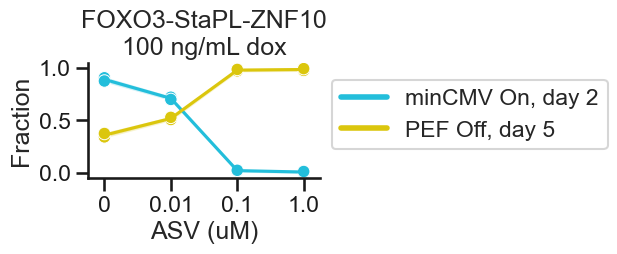

In [26]:
ddf = qdf[(qdf["effector"] == 73) & (qdf["dox"] == 100)]
ddf = ddf[
    ((ddf["reporter"] == "CMV") & (ddf["day"] == 2))
    | ((ddf["reporter"] == "PEF") & (ddf["day"] == 5))
]
ddf["asv_i"] = [asvs.index(a) for a in list(ddf["asv"])]

fig, ax = plt.subplots(figsize=(3, 1.5))

g = sns.lineplot(
    data=ddf,
    x="asv_i",
    y="mCitrine On",
    hue="reporter",
    palette=["#23bedb", "#dbc60d"],
    legend=False,
    ax=ax,
)
g = sns.scatterplot(
    data=ddf,
    x="asv_i",
    y="mCitrine On",
    hue="reporter",
    palette=["#23bedb", "#dbc60d"],
    legend=False,
    ax=ax,
)

ax.set_xlim(-0.25, 3.25)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels([0, 0.01, 0.1, 1.0])
ax.set_xlabel("ASV (uM)")
ax.set_ylabel("Fraction")
ax.set_ylim(-0.05, 1.05)
ax.set_yticks([0, 0.5, 1.0])

custom_lines = [
    Line2D([0], [0], color="#23bedb", lw=4),
    Line2D([0], [0], color="#dbc60d", lw=4),
]
ax.legend(
    custom_lines,
    ["minCMV On, day 2", "PEF Off, day 5"],
    title=None,
    loc="center left",
    bbox_to_anchor=(1.0, 0.55),
)

ax.set_title("FOXO3-StaPL-ZNF10\n100 ng/mL dox")

sns.despine()

fig.savefig("./plots/073_cmvpef_tradeoff.pdf", bbox_inches="tight")

## Summary Gridplot

In [66]:
sdf = qdf[qdf["effector"]==73]
sdf = sdf.groupby(["effector", "reporter", "asv", "dox", "day"]).mean().reset_index()
sdf = sdf[["effector", "reporter", "asv", "dox", "day", "mCitrine On"]]

sdf = sdf.pivot(
    index = ["effector", "asv", "dox", "day"],
    columns = "reporter",
    values = "mCitrine On"
).reset_index()

sdf["PEF"] = 1 - sdf["PEF"]
sdf["day"] = np.array(sdf["day"]).astype(int)
sdf = sdf.sort_values(by="day")
sdf

reporter,effector,asv,dox,day,CMV,PEF
0,73,0.00,10.0,0,0.000000,1.000000
24,73,0.10,10.0,0,0.000000,1.000000
12,73,0.01,10.0,0,0.000000,1.000000
42,73,1.00,100.0,0,0.000000,1.000000
6,73,0.00,100.0,0,0.000000,1.000000
30,73,0.10,100.0,0,0.000000,1.000000
36,73,1.00,10.0,0,0.000000,1.000000
18,73,0.01,100.0,0,0.000000,1.000000
7,73,0.00,100.0,1,0.808200,1.006318
31,73,0.10,100.0,1,0.165017,1.010584


In [45]:
def get_label_type(a, d, y):
    if a==0 and d==100 and y==5:
        return "FOXO 100 "

sdf

reporter,effector,asv,dox,day,CMV,PEF
0,73,0.00,10.0,0,0.000000,1.000000
1,73,0.00,10.0,1,0.053695,1.001746
2,73,0.00,10.0,2,0.221190,1.016806
3,73,0.00,10.0,3,0.479066,1.013568
4,73,0.00,10.0,4,0.562414,1.003193
5,73,0.00,10.0,5,0.572848,1.011812
6,73,0.00,100.0,0,0.000000,1.000000
7,73,0.00,100.0,1,0.808200,1.006318
8,73,0.00,100.0,2,0.889890,0.945108
9,73,0.00,100.0,3,0.903698,0.783684


Text(0, 0.5, 'PEF Frac. On')

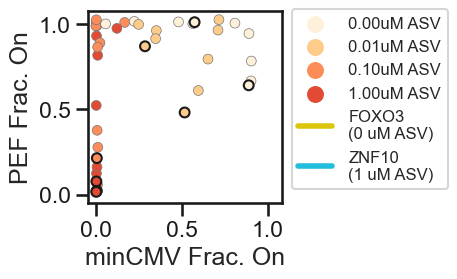

In [69]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))

# sns.kdeplot(
#     data=sdf,
#     x="CMV",
#     y="PEF",
#     fill=False,
#     cmap=sns.light_palette("lightsteelblue", as_cmap=True),
#     legend=False,
#     zorder=-10,
#     ax=ax,
# )

# for d in [0, 10, 100]:
#     sns.lineplot(
#         data=sdf[(sdf["asv"] == 0) & (sdf["dox"] == d)].sort_values(by="day"),
#         x="CMV",
#         y="PEF",
#         color="#dbc60d",
#         sort=False,
#         lw=3,
#         zorder=-5,
#         ax=ax,
#     )
#     sns.lineplot(
#         data=sdf[(sdf["asv"] == 1) & (sdf["dox"] == d)].sort_values(by="day"),
#         x="CMV",
#         y="PEF",
#         color="#23bedb",
#         sort=False,
#         lw=3,
#         zorder=-5,
#         ax=ax,
#     )


g = sns.scatterplot(
    data=sdf,
    x="CMV",
    y="PEF",
    hue="asv",
    palette=["#fef0d9", "#fdcc8a", "#fc8d59", "#e34a33"],
    ec=["#777777" if d < 5 else "k" for d in list(sdf["day"])],
    s=50,
    linewidth=[0.5 if d<5 else 1.5 for d in list(sdf["day"])],
    legend=True,
    ax=ax,
)


l = ax.legend(
    title="Day",
    bbox_to_anchor=(1.01, 1.05),
    labelspacing=0.5,
    handletextpad=1,
    fontsize=12,
)

handles, labels = ax.get_legend_handles_labels()
handles.append(Line2D([0], [0], color="#dbc60d", lw=4))
handles.append(Line2D([0], [0], color="#23bedb", lw=4))
labels = ["{:0.2f}uM ASV".format(float(i)) for i in labels]
labels.append("FOXO3\n(0 uM ASV)")
labels.append("ZNF10\n(1 uM ASV)")
l._legend_box = None
l._init_legend_box(handles, labels)
l._set_loc(l._loc)
l.set_title(None)
for h in l.legendHandles:
    h._sizes = [125]
    if not isinstance(h, Line2D):
#         h.set_edgecolor("darkblue")
        h.set_linewidth(1)


ax.set_xlim(-0.05, 1.08)
ax.set_ylim(-0.05, 1.08)
ax.set_xticks([0, 0.5, 1.0])
ax.set_yticks([0, 0.5, 1.0])
ax.set_xlabel("minCMV Frac. On")
ax.set_ylabel("PEF Frac. On")

fig.savefig("./plots/stapl_plane.pdf", bbox_inches="tight")